In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.10"):
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.22.4", 'matplotlib': "3.5.2",'sklearn': "1.1.1", 
                'pandas': "1.4.2",'xgboost': "1.5.1", 'shap': "0.40.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.10.5

[ OK ] numpy version 1.22.4 is installed.
[ OK ] matplotlib version 3.5.2 is installed.
[ OK ] sklearn version 1.1.1 is installed.
[ OK ] pandas version 1.4.2 is installed.


/Users/burkeobrien/opt/anaconda3/envs/ds_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[ OK ] xgboost version 1.5.1 is installed.
[ OK ] shap version 0.40.0 is installed.


In [5]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import seaborn as sb
from sklearn.model_selection import train_test_split 


In [6]:
df = pd.read_csv("../data/audi.csv")

### Preprocessing

**Splitting**

new fold
new fold
new fold
new fold


/Users/burkeobrien/opt/anaconda3/envs/ds_env/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


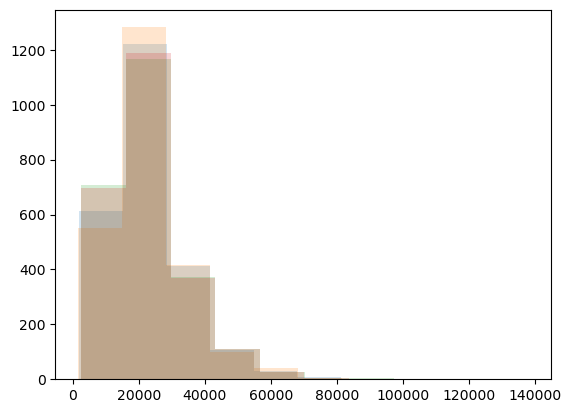

In [30]:
from sklearn.model_selection import StratifiedKFold

# Our dataset is large enough where we don't need to bother with KFolds
random_state = 42

y = df['price']
X = df.loc[:, df.columns != 'price']

# We're going to want to stratify on price
y_binned = pd.qcut(df['price'], q=50)

# first split to separate out the test set - set test to 10%
X_other, X_test, y_other, y_test = train_test_split(X,y,\
                    train_size = 0.9,random_state = random_state, stratify = y_binned)
#print('training set:',X_train.shape, y_train.shape) # 80% of points are in train
#print(X_other.shape, y_other.shape) # 20% of points are in other

#y_binned = pd.qcut(y_other, q=10)

# make kFolds, k = 5

kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=random_state)
for train_index, val_index in kf.split(X_other,y_other):
    print('new fold')
    X_train = X_other.iloc[train_index]
    y_train = y_other.iloc[train_index]
    X_val = X_other.iloc[val_index]
    y_val = y_other.iloc[val_index]
    #print(np.unique(y_train,return_counts=True))
    #print(np.unique(y_val,return_counts=True))
    plt.hist(y_val, alpha = 0.2)
    

# second split to separate out the validation and test sets
#X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,\
#                    train_size = 0.5,random_state = random_state, stratify = y_binned)
#print('validation set:',X_val.shape, y_val.shape) # 10% of points are in validation
#print('test set:',X_test.shape, y_test.shape) # 10% of points are in test
#plt.hist(y_test)

**Preprocessing**

In [38]:
# We want to group very rare models into an "other" category- say models that are less than 0.5% of our training data

rare_models = pd.DataFrame(df['model'].value_counts() / len(df))
rare_models = rare_models[rare_models['model'] < 0.005]

df['model'] = np.where(df['model'].isin(rare_models.index), 'Other', df['model'])

In [20]:
# Create the preprocess ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler

# categorical features
onehot_ftrs = ['model','fuelType','transmission']

# continuous with well-defined min/max
minmax_ftrs = ['year', 'engineSize']
# continuous better suited for StandardScaler
std_ftrs = ['tax', 'mileage', 'mpg']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs),
        ('onehot' , OneHotEncoder(sparse=False,min_frequency = 0.01, handle_unknown = 'infrequent_if_exist'), onehot_ftrs)
    ], remainder = 'passthrough', verbose_feature_names_out = False)

clf = Pipeline(steps=[('preprocessor', preprocessor)]) 


X_train_prep = pd.DataFrame(clf.fit_transform(X_train), columns = clf.get_feature_names_out())
X_val_prep = pd.DataFrame(clf.transform(X_val),  columns = clf.get_feature_names_out())
X_test_prep = pd.DataFrame(clf.transform(X_test),  columns = clf.get_feature_names_out())




In [21]:
print(X_train_prep['model_infrequent_sklearn'].sum() / len(X_train_prep))
print(X_test_prep['model_infrequent_sklearn'].sum() / len(X_test_prep))
print(X_val_prep['model_infrequent_sklearn'].sum() / len(X_val_prep))

0.024579919455631163
0.031865042174320526
0.03375


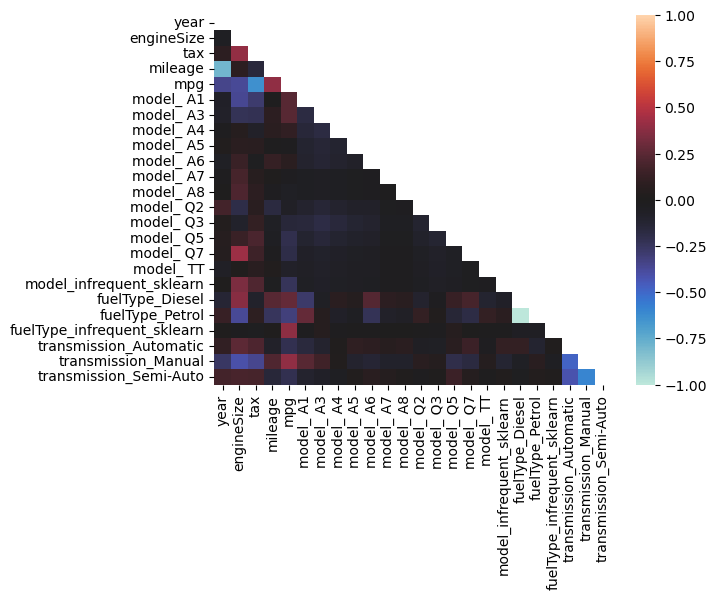

In [25]:
corr_m = X_train_prep.corr()
mask = np.triu(corr_m)

ax = sb.heatmap(corr_m, annot=False, center = 0,mask = mask, vmin = -1, vmax = 1)